# Using FastAI to classify SARS-COV-2-CT-Scan



*   adapted BY DrQ https://scholar.google.com/citations?user=eXKdSu0AAAAJ&hl=en
*   Data from: https://www.kaggle.com/plameneduardo/sarscov2-ctscan-dataset
*  adapted from: https://dlabs.ai/blog/introduction-to-deep-learning/  and https://blog.roboflow.com/custom-resnet34-classification-model/ 







In [ ]:
# Check if fastai and pytorch are installed
!pip list | grep -e fastai -e torch -e torchvision

# If not, uncomment this line and run to install them
#!pip install torch torchvision fastai

from fastai.vision import *
from fastai.metrics import accuracy

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import os

np.random.seed(42)


fastai                        1.0.61         
torch                         1.6.0+cu101    
torchsummary                  1.5.1          
torchtext                     0.3.1          
torchvision                   0.7.0+cu101    


In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

#dataset imported from 
!ls "/content/drive/My Drive/Images/SARS-COV-2-Ct-Scan"


Mounted at /content/drive
COVID  models  non-COVID


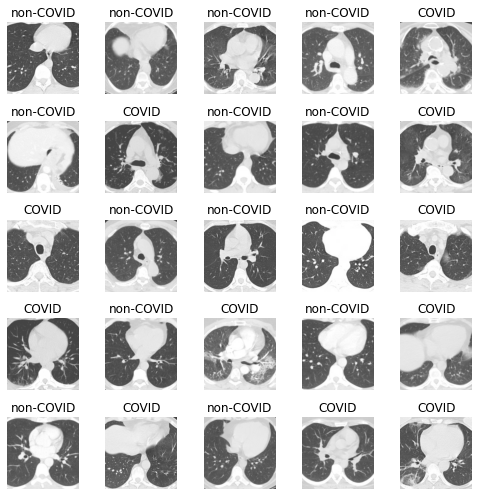

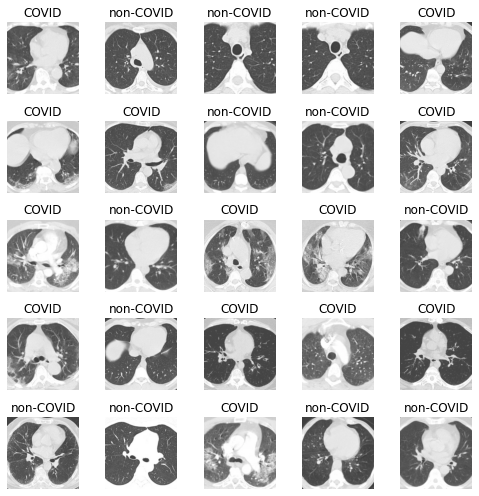

In [ ]:

#
#build fastai dataset loader

#fastai automatically factors the ./train and ./valid folders into seperate datasets
#more details https://docs.fast.ai/vision.data.html#ImageDataLoaders.from_folder
#path = Path('/content/drive/My Drive/Images/SARS-COV-2-Ct-Scan/')
data = ImageDataBunch.from_folder('/content/drive/My Drive/Images/SARS-COV-2-Ct-Scan/', valid_pct=0.2, size=224, num_workers=4, bs=32)
# data = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(do_flip=True, flip_vert=True),
 #                                 valid_pct=0.2, size=size, bs=bs)

#double check the data classes
data.classes
#take a peak at the batch to make sure things were loaded correctly
data.normalize(imagenet_stats)
data.show_batch(rows=5, figsize=(7, 7))
data.show_batch(rows=5, figsize=(7, 7))

In [ ]:
from fastai.metrics import error_rate # 1 - accuracy
learn = create_cnn(data, models.resnet34, metrics=error_rate)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:109: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
#print network layers
learn

Learner(data=ImageDataBunch;

Train: LabelList (1985 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
COVID,COVID,COVID,COVID,COVID
Path: /content/drive/My Drive/Images/SARS-COV-2-Ct-Scan;

Valid: LabelList (496 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
COVID,COVID,non-COVID,non-COVID,COVID
Path: /content/drive/My Drive/Images/SARS-COV-2-Ct-Scan;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=F

# Train Custom Resnet Image Classifier

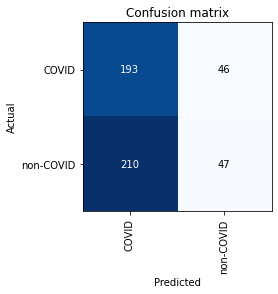

In [ ]:

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

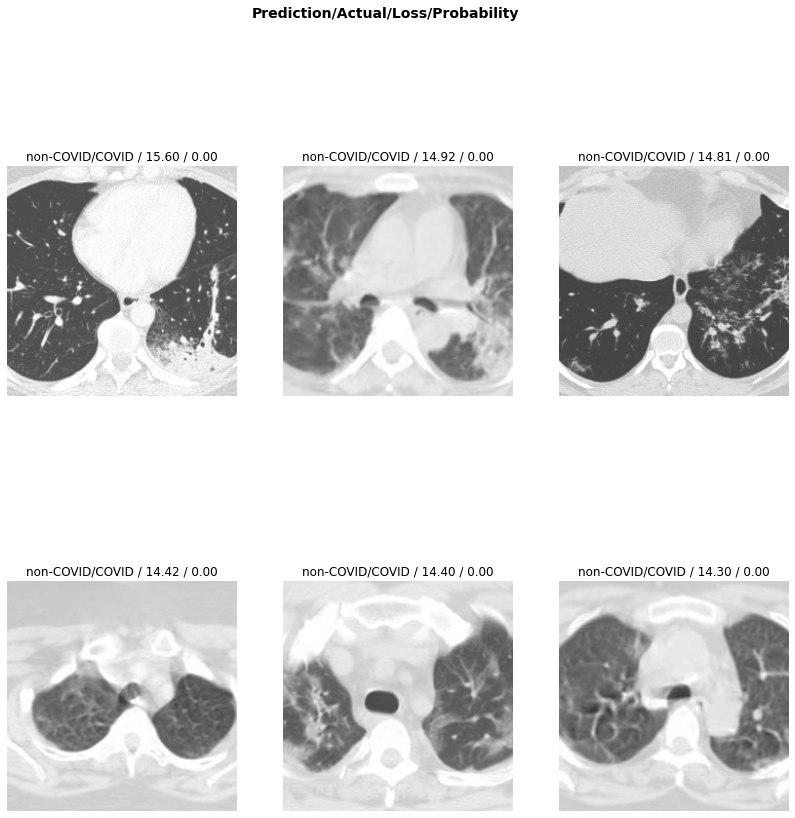

In [ ]:
interp.plot_top_losses(6, figsize=(14,14))


In [ ]:
from fastai.callbacks import *
early_stop = EarlyStoppingCallback(learn, patience=20)
save_best_model = SaveModelCallback(learn, name='best_resnet34')

In [ ]:
#frozen training step
defaults.device = torch.device('cuda') # makes sure the gpu is used
learn.fit_one_cycle(1, callbacks=[early_stop, save_best_model])

epoch,train_loss,valid_loss,error_rate,time
0,0.615714,0.443566,0.165323,03:01


Better model found at epoch 0 with valid_loss value: 0.4435662627220154.


In [ ]:
#load best model from frozen training
learn.load('best_resnet34')


Learner(data=ImageDataBunch;

Train: LabelList (1985 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
COVID,COVID,COVID,COVID,COVID
Path: /content/drive/My Drive/Images/SARS-COV-2-Ct-Scan;

Valid: LabelList (496 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
COVID,COVID,non-COVID,non-COVID,COVID
Path: /content/drive/My Drive/Images/SARS-COV-2-Ct-Scan;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=F

In [ ]:
learn.unfreeze()

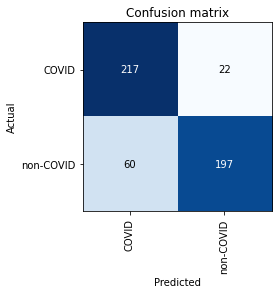

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
def find_appropriate_lr(model:Learner, lr_diff:int = 15, loss_threshold:float = .05, adjust_value:float = 1, plot:bool = False) -> float:
    #Run the Learning Rate Finder
    model.lr_find()
    
    #Get loss values and their corresponding gradients, and get lr values
    losses = np.array(model.recorder.losses)
    min_loss_index = np.argmin(losses)
    
    
    #loss_grad = np.gradient(losses)
    lrs = model.recorder.lrs
    
    #return the learning rate that produces the minimum loss divide by 10   
    return lrs[min_loss_index] / 10

In [ ]:
optimal_lr = find_appropriate_lr(learn)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


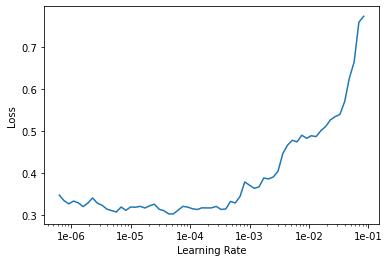

In [ ]:
learn.recorder.plot()



In [ ]:
learn.fit_one_cycle(8, max_lr=slice(optimal_lr/10, optimal_lr), callbacks=[early_stop, save_best_model])


epoch,train_loss,valid_loss,error_rate,time
0,0.333301,0.377593,0.131048,00:23
1,0.343722,0.345819,0.114919,00:23
2,0.319763,0.316841,0.106855,00:23
3,0.271324,0.311419,0.096774,00:23
4,0.259896,0.303388,0.094758,00:22
5,0.220794,0.295911,0.090726,00:22
6,0.206007,0.289594,0.090726,00:22
7,0.191158,0.286543,0.090726,00:22


Better model found at epoch 0 with valid_loss value: 0.37759312987327576.
Better model found at epoch 1 with valid_loss value: 0.345819354057312.
Better model found at epoch 2 with valid_loss value: 0.3168405592441559.
Better model found at epoch 3 with valid_loss value: 0.31141945719718933.
Better model found at epoch 4 with valid_loss value: 0.3033875823020935.
Better model found at epoch 5 with valid_loss value: 0.2959112226963043.
Better model found at epoch 6 with valid_loss value: 0.2895944118499756.
Better model found at epoch 7 with valid_loss value: 0.28654295206069946.


Learner(data=ImageDataBunch;

Train: LabelList (1985 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
COVID,COVID,COVID,COVID,COVID
Path: /content/drive/My Drive/Images/SARS-COV-2-Ct-Scan;

Valid: LabelList (496 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
COVID,COVID,non-COVID,non-COVID,COVID
Path: /content/drive/My Drive/Images/SARS-COV-2-Ct-Scan;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=F

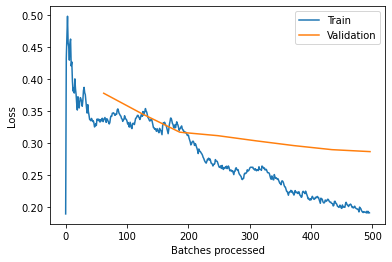

In [ ]:
learn.recorder.plot_losses()

learn.load('best_resnet34')


# Evaluate Classifier Performance

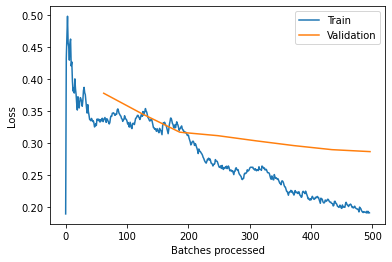

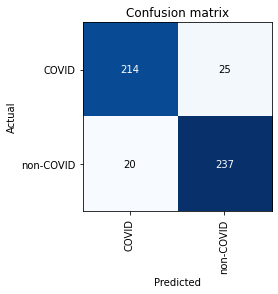

In [ ]:
learn.recorder.plot_losses()

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()


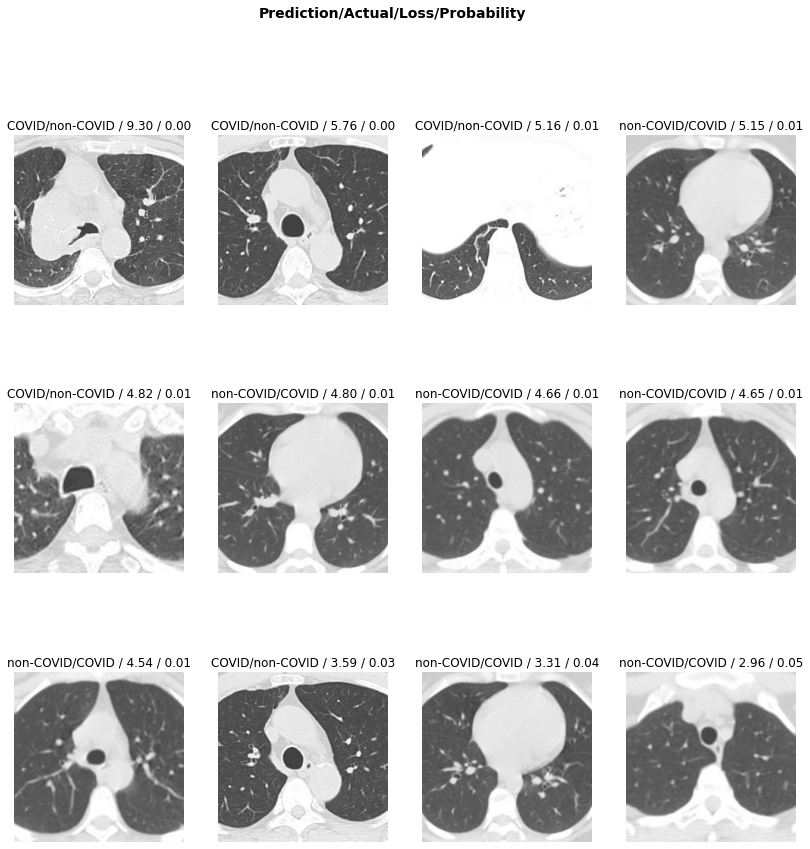

In [ ]:
interp.plot_top_losses(12, figsize=(14,14))


In [ ]:
#run inference on test images
import glob
from IPython.display import Image, display

!ls '/content/drive/My Drive/Images/test/*.jpg'
model = learn.model
model = model.cuda()
for imageName in glob.glob('/content/drive/My Drive/Images/test/*.png'):
    print(imageName)
    img = open_image(imageName)
    prediction = learn.predict(img)
    print(prediction)
    print(prediction[0])
    display(Image(filename=imageName))
    print("\n")